In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# QC of sensor data

There is NIVA sensor data for 2023 for Glomma. Aim in this notebook is to do a quick manual QC of this data. There are already automated QC procedures in place, but these tend to be too stringent for some parameters, e.g. turbidity which is spiky. Aim in AquaInfra to work with Ivana to improve these QC routines.

Data is from NIVA station 'Baterød', which I think is located adjacent to where the elveovervåking samples are taking (needs checking!). Leah JB downloaded the latest data on 2024-08-28 and it is stored here: aquainfra/data/river/sensors/glomma_sensor_data_raw_2024-08-28.csv

To do:
* Plot the 6 data columns and see whether there are dodgy values
* Work with Ivana to see whether the quality flags that have already been assigned are useful in identifying dodgy values or are too lax/strict
* Come up with new quality flags to remove dodgy data
* Fill any gaps in the data in a sensible way. E.g. linear interpolation if they are short
* Save cleaned high frequency data
* Convert to daily means and save again

In [2]:
# User's input

fpath = r'../../data/river/sensors/glomma_sensor_data_raw_2024-08-28.csv'

variables = ['CDOMdigitalFinal (µg/L)', 'PhValue_Avg (-)', 'Temp_water_Avg (degC)', 
             'CondValue_Avg (µS/cm)', 'Turbidity_Avg (NTU)', 'Salinity_Avg (-)']

variables_flags = [
    ('CDOMdigitalFinal (µg/L)', 'QC flag CDOMdigitalFinal'),
    ('PhValue_Avg (-)', 'QC flag PhValue_Avg'),
    ('Temp_water_Avg (degC)', 'QC flag Temp_water_Avg'),
    ('CondValue_Avg (µS/cm)', 'QC flag CondValue_Avg'),
    ('Turbidity_Avg (NTU)', 'QC flag Turbidity_Avg'),
    ('Salinity_Avg (-)', 'QC flag Salinity_Avg')
]

variables_flags_manual = [
    ('CDOMdigitalFinal (µg/L)', 'CDOMdigitalFinal_outlier_manual'),
    ('PhValue_Avg (-)', 'PhValue_Avg_outlier_manual'),
    ('Temp_water_Avg (degC)', 'Temp_water_Avg_outlier_manual'),
    ('CondValue_Avg (µS/cm)', 'CondValue_Avg_outlier_manual'),
    ('Turbidity_Avg (NTU)', 'Turbidity_Avg_outlier_manual'),
    ('Salinity_Avg (-)', 'Salinity_Avg_outlier_manual')
]

### 1. Read in file

In [3]:
df = pd.read_csv(fpath, index_col=0, parse_dates=True)

df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df.set_index('Datetime', inplace=True)
df['Month'] = df.index.to_period('M')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13726 entries, 2023-02-02 15:00:00 to 2024-08-27 12:00:00
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype    
---  ------                    --------------  -----    
 0   Date                      13726 non-null  object   
 1   Time                      13726 non-null  object   
 2   CDOMdigitalFinal (µg/L)   13726 non-null  float64  
 3   QC flag CDOMdigitalFinal  13719 non-null  object   
 4   PhValue_Avg (-)           13724 non-null  float64  
 5   QC flag PhValue_Avg       13717 non-null  object   
 6   Temp_water_Avg (degC)     13725 non-null  float64  
 7   QC flag Temp_water_Avg    13718 non-null  object   
 8   CondValue_Avg (µS/cm)     13725 non-null  float64  
 9   QC flag CondValue_Avg     13718 non-null  object   
 10  Turbidity_Avg (NTU)       13726 non-null  float64  
 11  QC flag Turbidity_Avg     13719 non-null  object   
 12  Salinity_Avg (-)          13725 non-null  float64  
 

### 2. Plot raw data

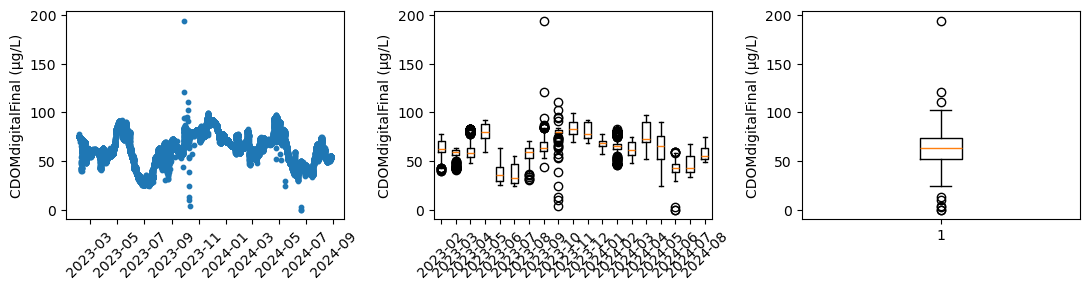

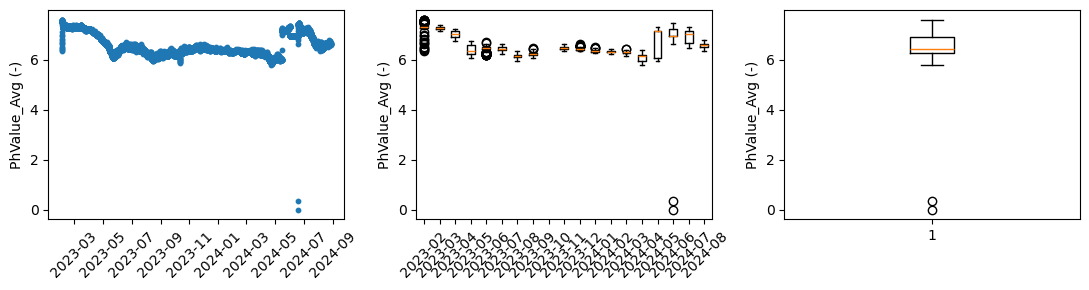

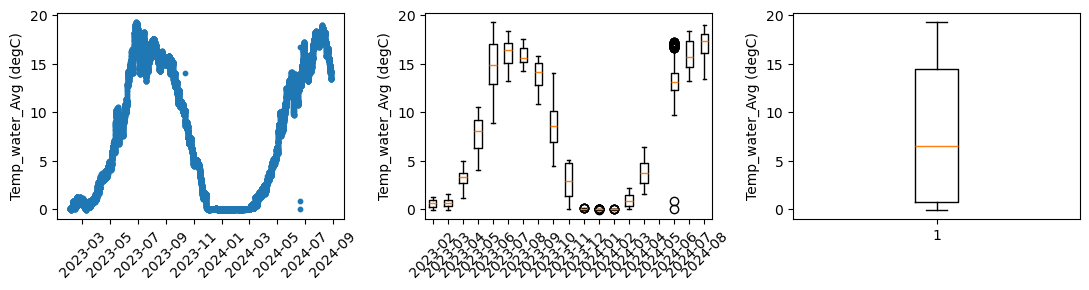

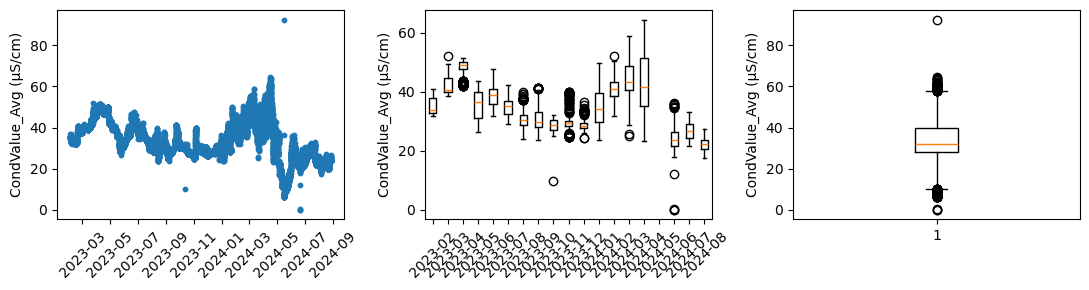

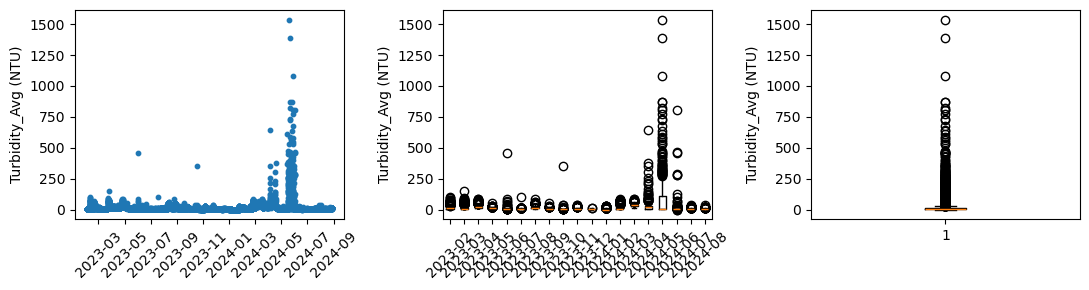

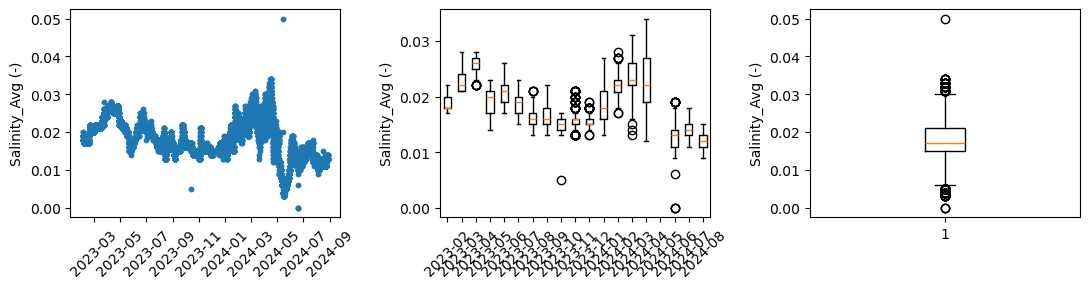

In [4]:
variables = ['CDOMdigitalFinal (µg/L)', 'PhValue_Avg (-)', 'Temp_water_Avg (degC)', 
             'CondValue_Avg (µS/cm)', 'Turbidity_Avg (NTU)', 'Salinity_Avg (-)']

for var in variables:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 3))

    # Scatter plot
    ax1.scatter(df.index, df[var], s=10)
    ax1.set_ylabel(var)
    ax1.tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    # Monthly boxplots
    df_monthly = df.groupby('Month')[var].apply(list).reset_index()
    ax2.boxplot(df_monthly[var].dropna(), positions=range(len(df_monthly)))
    ax2.set_ylabel(var)
    ax2.set_xticklabels(df_monthly['Month'].astype(str), rotation=45)

    # Boxplot
    ax3.boxplot(df[var].dropna())
    ax3.set_ylabel(var)

    plt.tight_layout()
    plt.show()


### 3. Plot the raw data with the quality flags that have already been assigned  

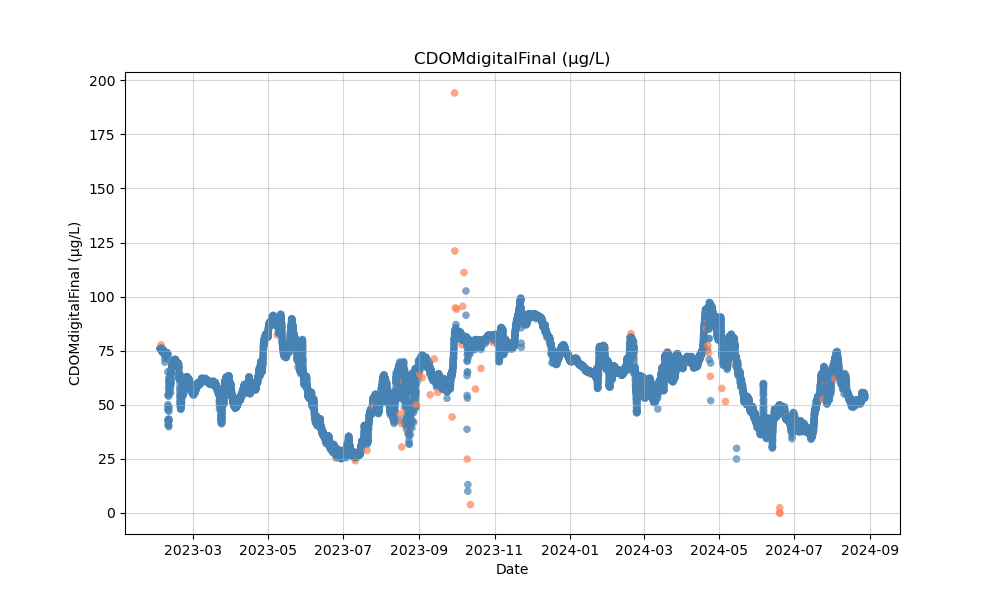

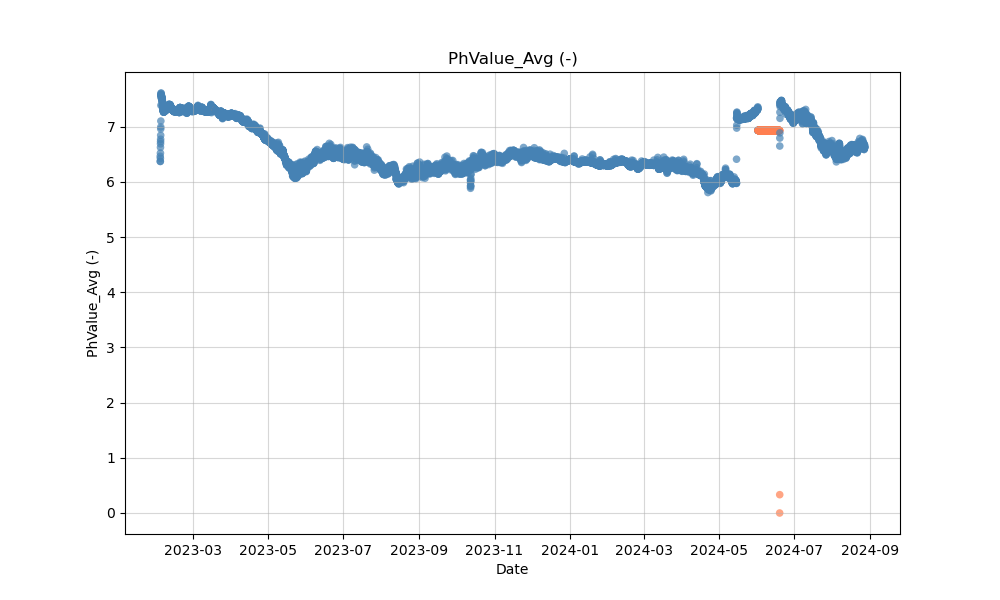

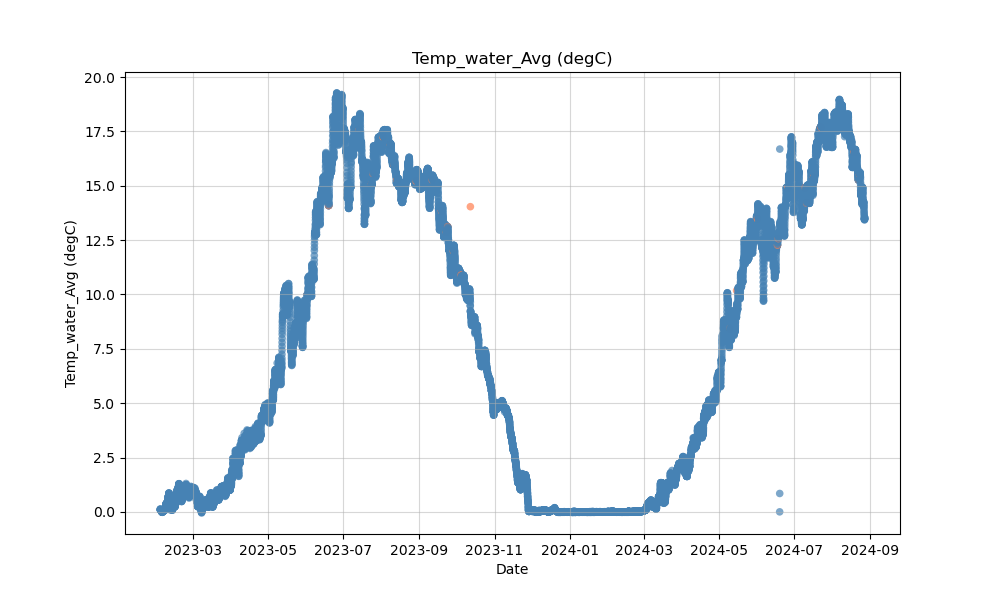

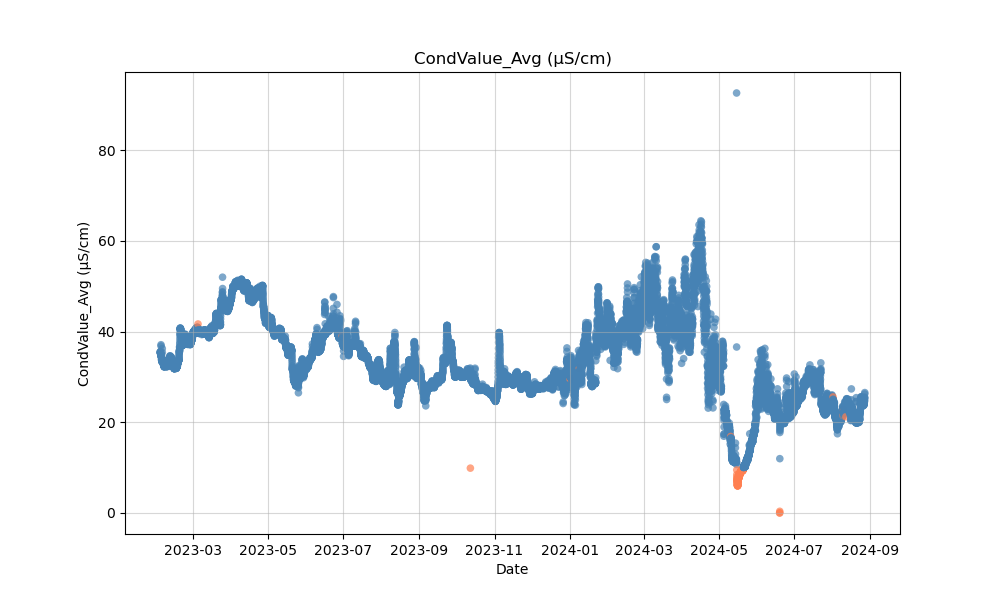

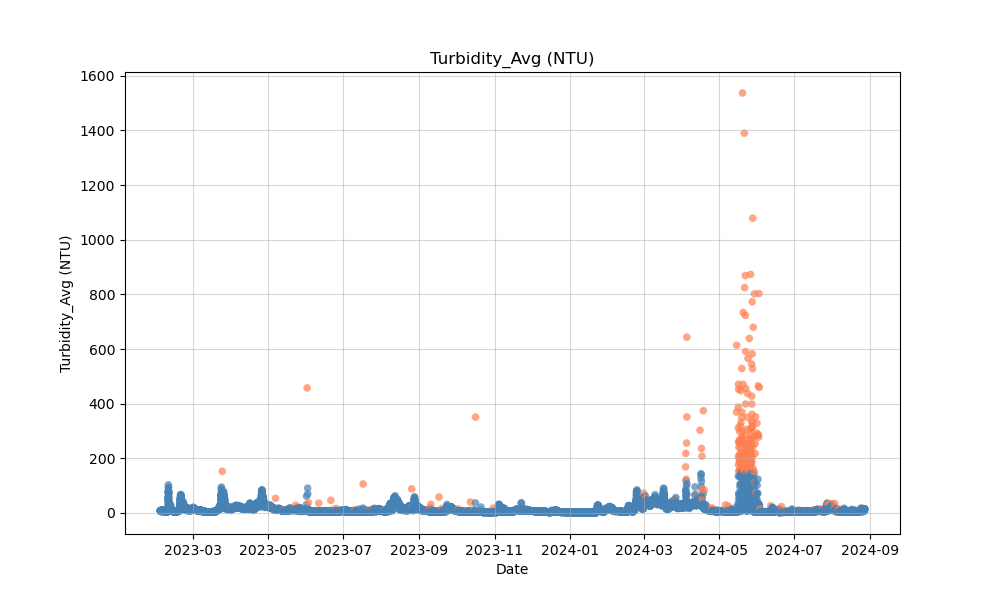

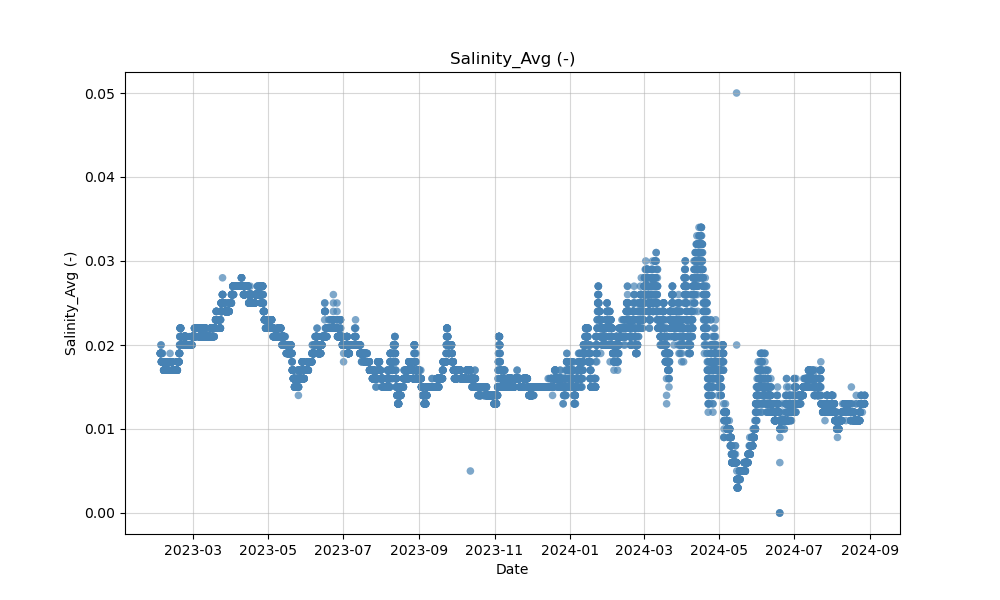

In [5]:
# Interactive plotting
%matplotlib widget

def plot_variable(df, variable, outlier, qc_flag):
    # Create a new column to identify bad values
    df['Color'] = df[qc_flag].apply(lambda x: 'coral' if x == outlier else 'steelblue')
    
    # Plot the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(df.index, df[variable], c=df['Color'], edgecolors='none', alpha=0.7, s=30)
    plt.xlabel('Date')
    plt.ylabel(variable)
    plt.title(f'{variable}')
    plt.grid(True, alpha =0.5)
    plt.show()

for variable, qc_flag in variables_flags:
    plot_variable(df, variable, 'Bad', qc_flag)

**Note:** I believe the quality flags currently assigned may be either too lenient or too strict, depending on the variable in question. For instance, no outliers have been flagged for salinity, yet there appear to be potential outliers, such as a value in May 2024 exceeding 0.05. In contrast, all turbidity values for the same period (May 2024) seem reasonable, especially given the low salinity levels indicative of substantial freshwater input during that time.

### 4. Manually specify outlier conditions

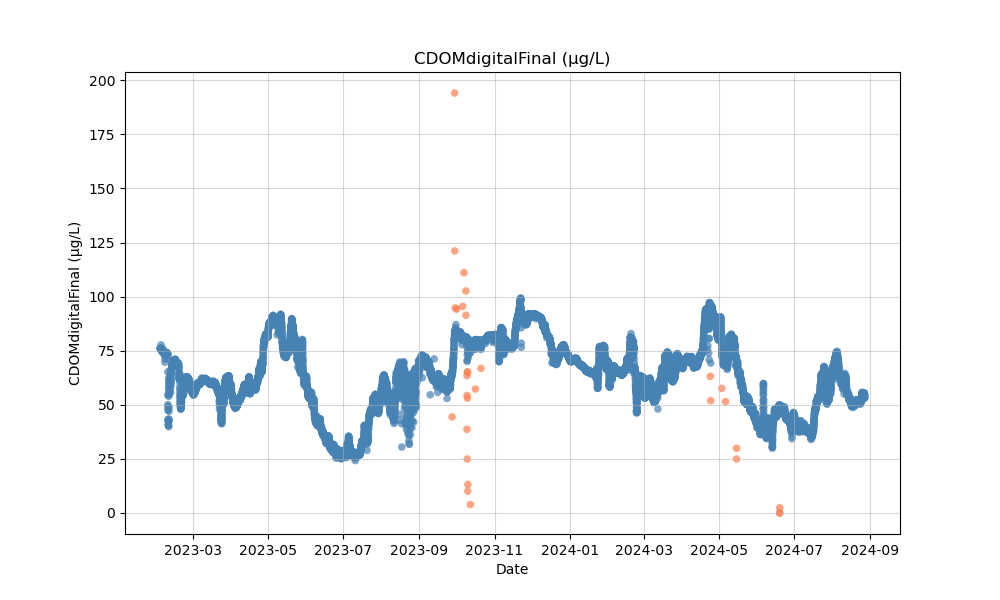

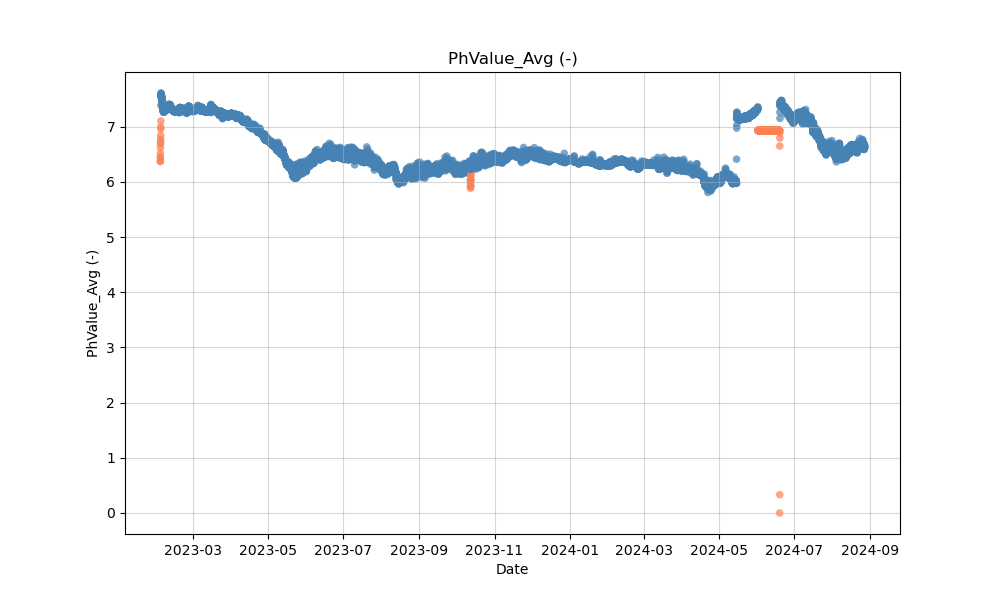

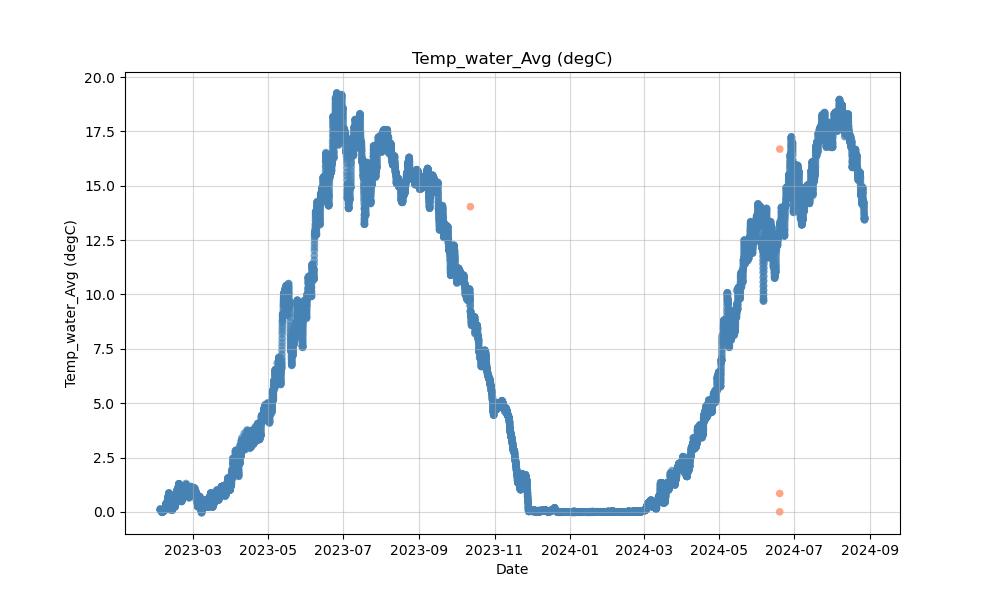

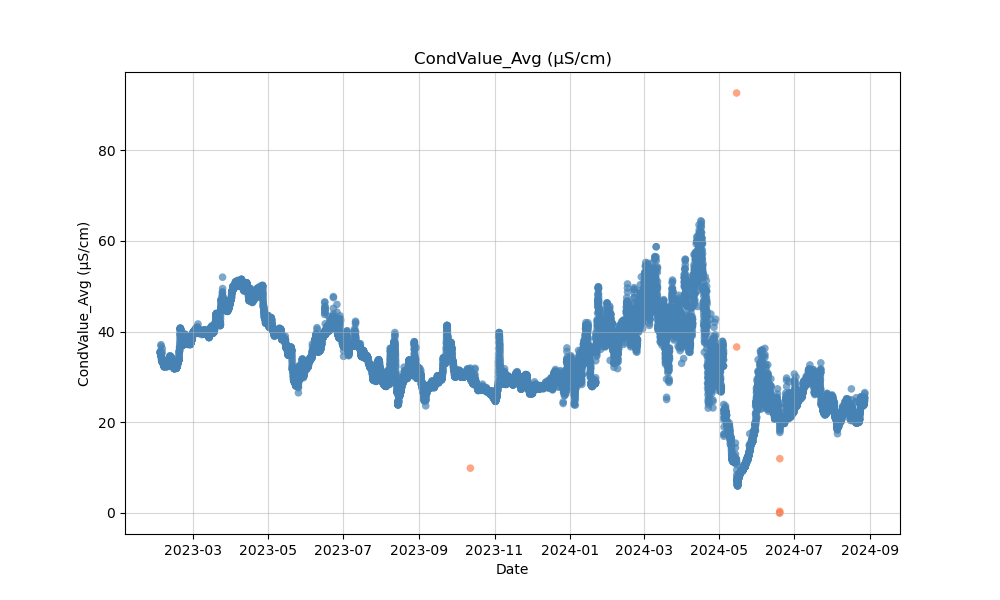

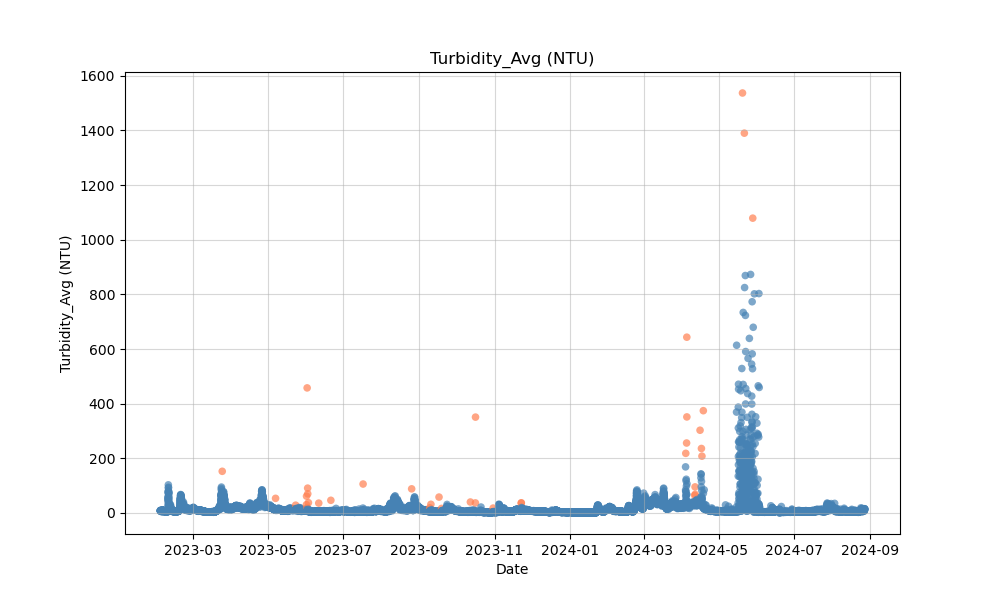

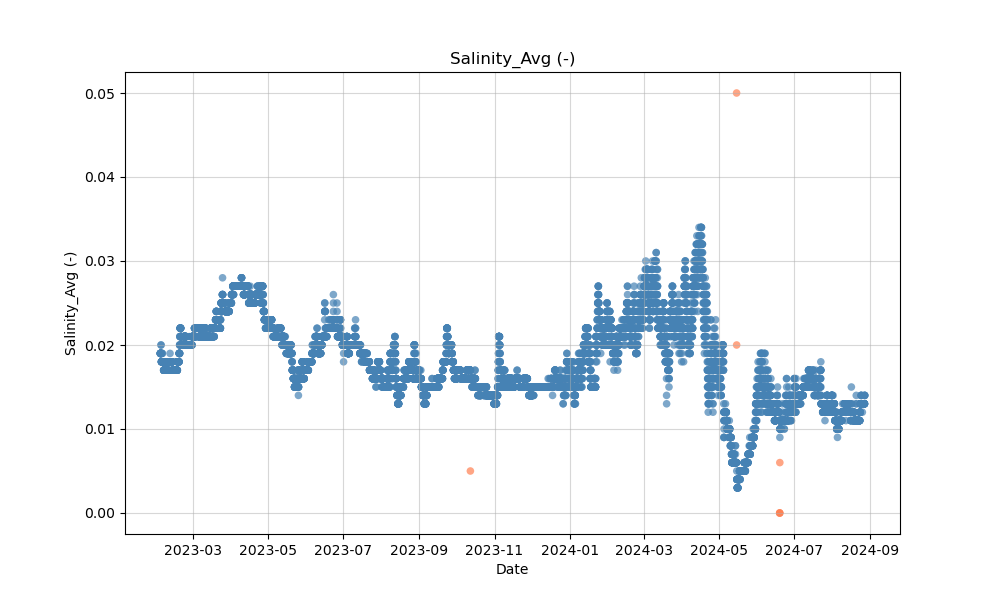

In [6]:
# Define the conditions for outliers
df['Date'] = pd.to_datetime(df['Date'])

def identify_CDOMoutliers(row):
    if row['CDOMdigitalFinal (µg/L)'] > 102 or row['CDOMdigitalFinal (µg/L)'] < 12:
        return 1
    if row['Date'].year == 2023 and row['Date'].month == 9 and row['CDOMdigitalFinal (µg/L)'] > 93:
        return 1
    if row['Date'].year == 2023 and row['Date'].month == 9 and row['CDOMdigitalFinal (µg/L)'] < 45:
        return 1
    if row['Date'].year == 2023 and row['Date'].month == 10 and row['CDOMdigitalFinal (µg/L)'] < 67:
        return 1
    if row['Date'].year == 2023 and row['Date'].month == 10 and row['CDOMdigitalFinal (µg/L)'] > 90:
        return 1
    if row['Date'].year == 2024 and row['Date'].month == 4 and row['CDOMdigitalFinal (µg/L)'] < 65:
        return 1
    if row['Date'].year == 2024 and row['Date'].month == 5 and row['CDOMdigitalFinal (µg/L)'] < 30:
        return 1
    if row['Date'] == pd.Timestamp('2024-05-03') and row['CDOMdigitalFinal (µg/L)'] < 58:
        return 1
    if row['Date'] == pd.Timestamp('2024-05-06') and row['CDOMdigitalFinal (µg/L)'] < 53:
        return 1
    if row['Date'].year == 2024 and row['Date'].month == 9 and row['CDOMdigitalFinal (µg/L)'] < 63:
        return 1
    return 0

def identify_PHoutliers(row):
    if row['PhValue_Avg (-)'] <1:
        return 1
    if row['Date'] == pd.Timestamp('2023-02-02') and row['PhValue_Avg (-)'] < 7.2:
        return 1
    if row['Date'] == pd.Timestamp('2023-02-03') and row['PhValue_Avg (-)'] < 7.2:
        return 1
    if row['Date'] == pd.Timestamp('2023-10-12') and row['PhValue_Avg (-)'] < 6.2:
        return 1
    if row['Date'].year == 2024 and row['Date'].month == 6 and row['PhValue_Avg (-)'] < 7:
        return 1
    return 0

def identify_TEMPoutliers(row):
    if row['Date'].year == 2023 and row['Date'].month == 10 and row['Temp_water_Avg (degC)'] > 13:
        return 1
    if row['Date'].year == 2024 and row['Date'].month == 6 and row['Temp_water_Avg (degC)'] < 2:
        return 1
    if row['Date'] == pd.Timestamp('2024-06-19') and row['Temp_water_Avg (degC)'] > 15:
        return 1
    return 0
    

def identify_CONDoutliers(row):
    if row['Date'].year == 2023 and row['Date'].month == 10 and row['CondValue_Avg (µS/cm)'] < 20:
        return 1
    if row['Date'].year == 2024 and row['Date'].month == 5 and row['CondValue_Avg (µS/cm)'] > 80:
        return 1
    if row['Date'] == pd.Timestamp('2024-05-15') and row['CondValue_Avg (µS/cm)'] > 30:
        return 1
    if row['Date'] == pd.Timestamp('2024-06-19') and row['CondValue_Avg (µS/cm)'] < 15:
        return 1
    return 0

def identify_TURBoutliers(row):
    if row['Date'].year == 2023 and row['Date'].month == 3 and row['Turbidity_Avg (NTU)'] > 140:
        return 1
    if row['Date'].year == 2023 and row['Date'].month == 6 and row['Turbidity_Avg (NTU)'] > 300:
        return 1
    if row['Date'].year == 2023 and row['Date'].month == 10 and row['Turbidity_Avg (NTU)'] > 200:
        return 1
    if row['Date'] == pd.Timestamp('2023-05-07') and row['Turbidity_Avg (NTU)'] > 50:
        return 1
    if row['Date'] == pd.Timestamp('2023-05-23') and row['Turbidity_Avg (NTU)'] > 25:
        return 1
    if row['Date'] == pd.Timestamp('2023-06-11') and row['Turbidity_Avg (NTU)'] > 25:
        return 1
    if row['Date'] == pd.Timestamp('2023-06-21') and row['Turbidity_Avg (NTU)'] > 25:
        return 1
    if row['Date'] == pd.Timestamp('2023-06-01') and row['Turbidity_Avg (NTU)'] > 18.8:
        return 1
    if row['Date'] == pd.Timestamp('2023-06-02') and row['Turbidity_Avg (NTU)'] > 18.8:
        return 1
    if row['Date'].year == 2023 and row['Date'].month == 7 and row['Turbidity_Avg (NTU)'] > 100:
        return 1
    if row['Date'].year == 2023 and row['Date'].month == 8 and row['Turbidity_Avg (NTU)'] > 80:
        return 1
    if row['Date'].year == 2023 and row['Date'].month == 9 and row['Turbidity_Avg (NTU)'] > 50:
        return 1
    if row['Date'] == pd.Timestamp('2023-09-09') and row['Turbidity_Avg (NTU)'] > 15:
        return 1
    if row['Date'] == pd.Timestamp('2023-09-10') and row['Turbidity_Avg (NTU)'] > 20:
        return 1
    if row['Date'] == pd.Timestamp('2023-09-18') and row['Turbidity_Avg (NTU)'] > 15:
        return 1
    if row['Date'] == pd.Timestamp('2023-10-12') and row['Turbidity_Avg (NTU)'] > 25:
        return 1
    if row['Date'] == pd.Timestamp('2023-10-16') and row['Turbidity_Avg (NTU)'] > 25:
        return 1
    if row['Date'] == pd.Timestamp('2023-10-20') and row['Turbidity_Avg (NTU)'] > 20:
        return 1
    if row['Date'] == pd.Timestamp('2023-10-30') and row['Turbidity_Avg (NTU)'] > 15:
        return 1
    if row['Date'] == pd.Timestamp('2023-11-22') and row['Turbidity_Avg (NTU)'] > 30:
        return 1
    if row['Date'] == pd.Timestamp('2024-04-11') and row['Turbidity_Avg (NTU)'] > 60:
        return 1
    if row['Date'].year == 2024 and row['Date'].month == 4 and row['Turbidity_Avg (NTU)'] > 200:
        return 1
    if row['Date'].year == 2024 and row['Date'].month == 5 and row['Turbidity_Avg (NTU)'] > 1000:
        return 1
    return 0

def identify_SALoutliers(row):
    if row['Date'].year == 2023 and row['Date'].month == 10 and row['Salinity_Avg (-)'] < 0.01:
        return 1
    if row['Date'].year == 2024 and row['Date'].month == 5 and row['Salinity_Avg (-)'] > 0.04:
        return 1
    if row['Date'] == pd.Timestamp('2024-05-15') and row['Salinity_Avg (-)'] > 0.01:
        return 1
    if row['Date'] == pd.Timestamp('2024-06-19') and row['Salinity_Avg (-)'] < 0.008:
        return 1
    return 0

# Apply functions to create the outlier columns
df['CDOMdigitalFinal_outlier_manual'] = df.apply(identify_CDOMoutliers, axis=1)
df['PhValue_Avg_outlier_manual'] = df.apply(identify_PHoutliers, axis=1)
df['Temp_water_Avg_outlier_manual'] = df.apply(identify_TEMPoutliers, axis=1)
df['CondValue_Avg_outlier_manual'] = df.apply(identify_CONDoutliers, axis=1)
df['Turbidity_Avg_outlier_manual'] = df.apply(identify_TURBoutliers, axis=1)
df['Salinity_Avg_outlier_manual'] = df.apply(identify_SALoutliers, axis=1)


# Plot
for variable, qc_flag in variables_flags_manual:
    plot_variable(df, variable, 1, qc_flag)

### 5. Replace outliers with NaNs

In [7]:
def replace_outliers_with_nan(df, variable, outlier_column):
    df.loc[df[outlier_column] == 1, variable] = np.nan

for variable, outlier_column in variables_flags_manual:
    replace_outliers_with_nan(df, variable, outlier_column)

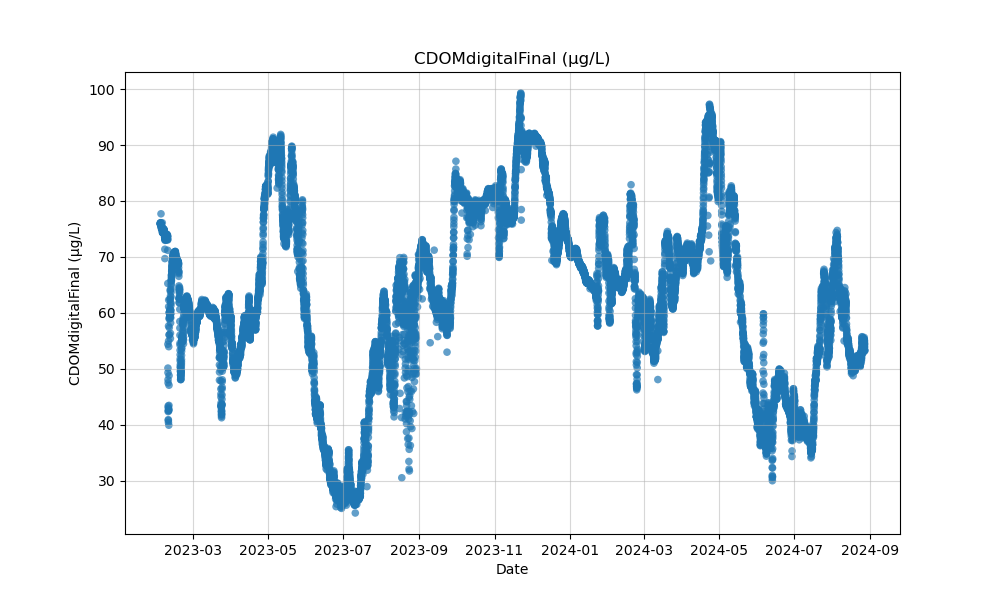

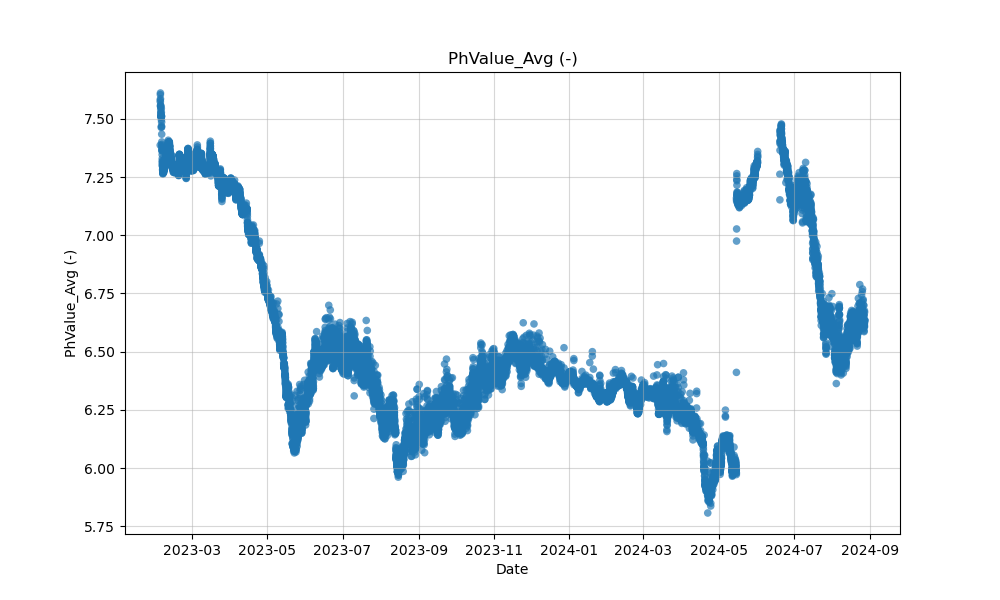

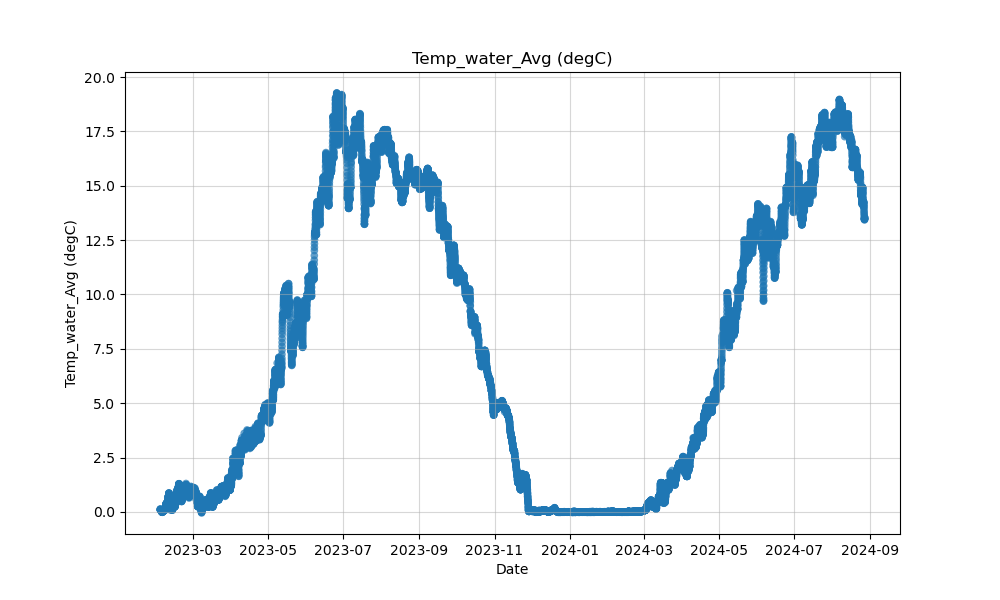

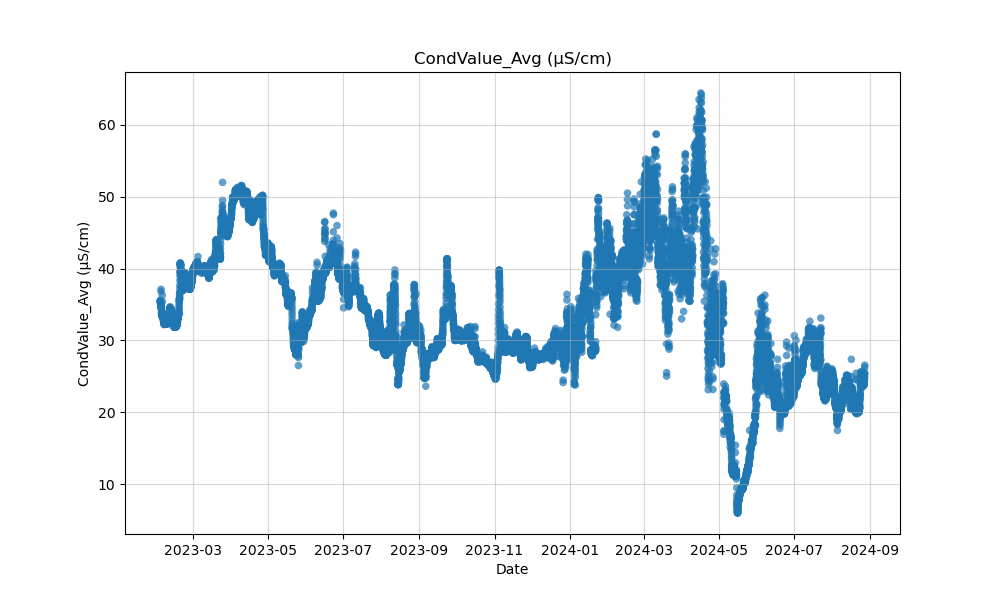

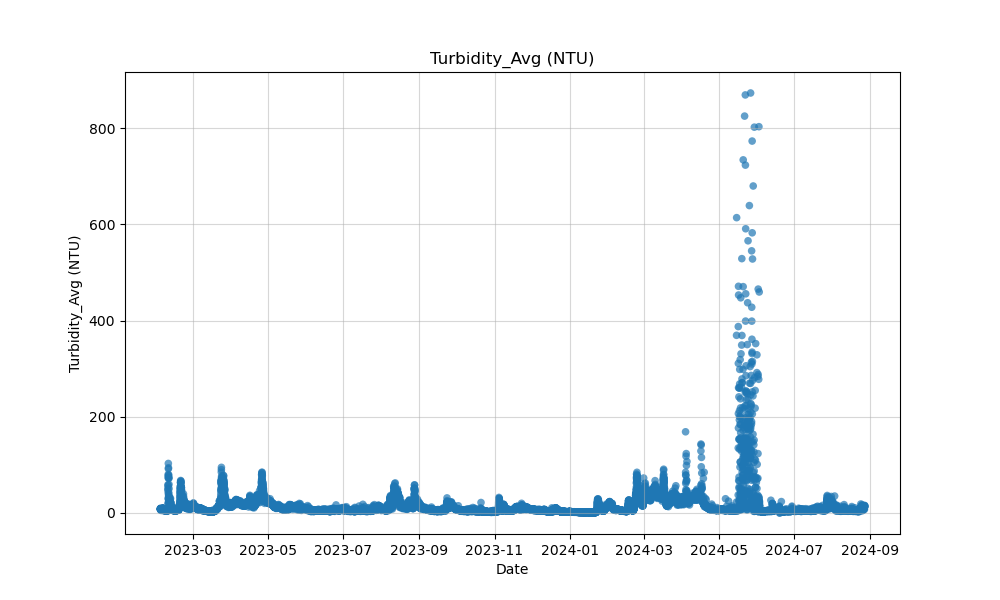

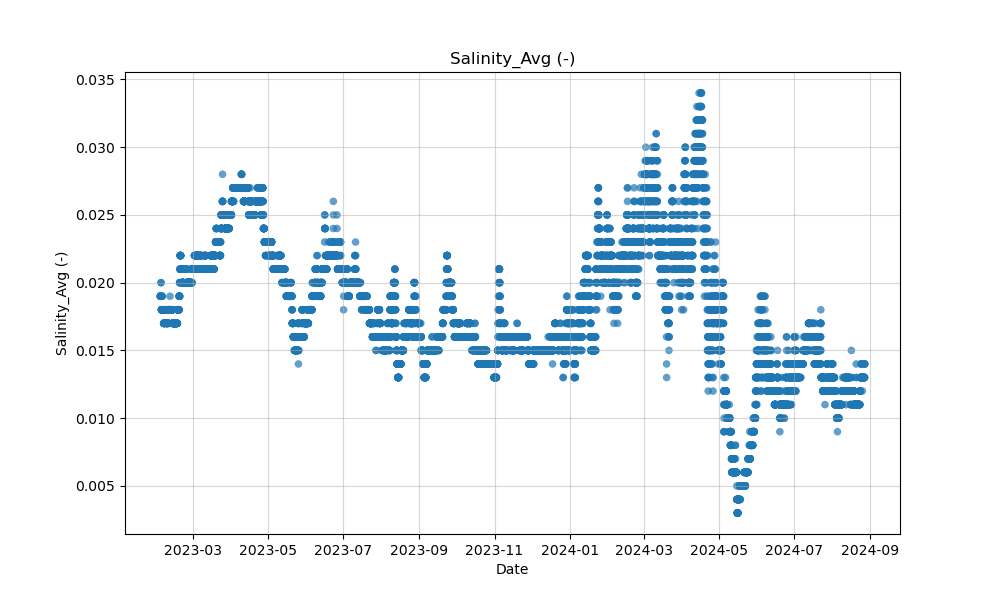

In [8]:
# Plot variables without outliers
for variable in variables:
    plt.figure(figsize=(10, 6))
    plt.scatter(df.index, df[variable], edgecolors='none', alpha=0.7, s=30)
    plt.xlabel('Date')
    plt.ylabel(variable)
    plt.title(f'{variable}')
    plt.grid(True, alpha =0.5)
    plt.show()


In [9]:
# Linear interpolation and save

In [10]:
# Daily means (before and after data cleaning) and comparison with discharges 

In [11]:
# Daily means and save